In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc

rc('axes', labelsize=12)
rc('font', size=12)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

from superlim import optimuminterval
from wimpnuclearscattering.WIMP_model import dRdE_SHM




# Ge 0V

In [2]:
def generate_spec(tm, time_elapsed, threshold, upperthreh, cutefficiency,
                  bgrate, makeplot = False):
    if (tm == "Ge"):
        detector_mass = 1.39 # kg #0.61 for Si
    elif (tm == "Si"):
        detector_mass = 0.61 # kg
    #time_elapsed = 20 # day
    exposure = detector_mass * time_elapsed # units of kg * day

    #cutefficiency = 0.8
    # Z1 has a baseline resolution of 54 eV with NxM. take the 5-sigma value as 270 eV
    #threshold = 0.270 # keV
    # detector saturates with worsen resolution
    #upperthreh = 50 #keV  


    # assume a background of 8 DRU (counts/keV/kg/day)
    #bgrate = 7 # DRU
    # assume flat background
    nbevents = int(np.random.poisson(bgrate * detector_mass * time_elapsed * (upperthreh - threshold)))
    #print (nbevents)
    eventenergies = np.random.uniform(threshold, upperthreh, nbevents)
    #eventenergies = np.loadtxt('./txt/cuter37_Ge0V.txt') # generated data in keV

    effrange = (threshold, 3*threshold) # keV, will be passed to the OI code to denote the nonzero efficiency range


    ######## plot
    if (makeplot):
        fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))

        ax.hist(
            eventenergies,
            histtype='step',
            color='k',
            linewidth=2,
            bins=90,
            label="Event Spectrum",
        )

        #ax.set_ylim(0, 30)
        ax.set_xlim(0, upperthreh)
        ax.set_xlabel("Reconstructed Energy [keV]")
        ax.set_ylabel("Counts per 10 eV")

        ax.legend(loc="upper left", edgecolor='k', framealpha=1)
        ax.grid(linestyle='dotted')
        ax.tick_params(which="both", direction="in", right=True, top=True)

        fig.tight_layout()
    #########
    return eventenergies, effrange, exposure
    
#eventenergies, effrange, exposure = generate_spec(makeplot=True)

In [3]:
def efficiency(eventenergies):
    return np.heaviside(eventenergies - threshold, 0) * cutefficiency

def signalmodel(eventenergies, candidateval):
    return efficiency(eventenergies) * dRdE_SHM(eventenergies, candidateval, refval, tm=tm)

In [17]:
refval = 1e-40 # reference cross section to pass to OI code, in units of cm^2

tm = "Ge"
threshold = 0.25
upperthreh = 50
cutefficiency = 0.8
time_elapsed = 10
bgrate = 8


outvals_list = []

for test in range(100):

    eventenergies, effrange, exposure = generate_spec(tm=tm, threshold=threshold, 
                                                      upperthreh=upperthreh,
                                                      cutefficiency=cutefficiency,
                                                      time_elapsed=time_elapsed,
                                                      bgrate=bgrate)

    candidatevals = np.geomspace(1.5, 15, num=25) # dark matter masses in GeV/c^2

    outvals, oi0, oi1 = optimuminterval(
        eventenergies,
        signalmodel,
        candidatevals,
        refval,
        effrange,
        exposure,
    )
    outvals_list.append(outvals)

# get the maximum and minimum outvals for each DM mass
#print (outvals_list)

outvals_list = np.array(outvals_list)
max_outvals = np.max(outvals_list, axis=0)
min_outvals = np.min(outvals_list, axis=0)
avg_outvals = (max_outvals+min_outvals)/2

#print(avg_outvals)

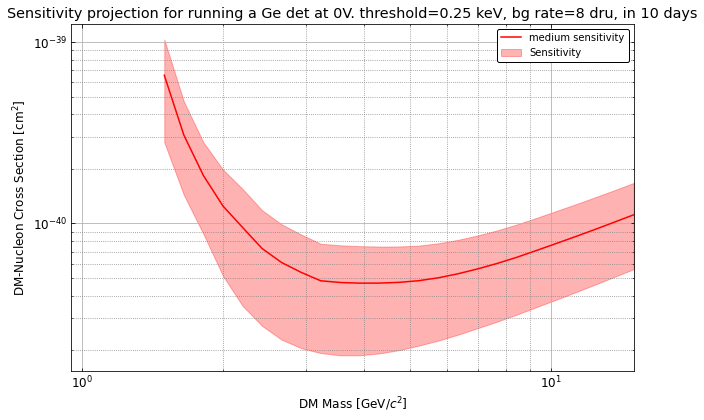

In [18]:
fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/1))

ax.loglog(
    candidatevals,
    avg_outvals,
    color='r',
    label="medium sensitivity",
)

ax.fill_between(
    candidatevals,
    min_outvals,
    max_outvals,
    color='r',
    alpha=0.3,
    label='Sensitivity')

#ax.set_ylim(1e-37, 1e-33)
ax.set_xlim(0.95, 15)
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel(r"DM Mass [GeV$/c^2$]")
ax.set_ylabel(r"DM-Nucleon Cross Section [cm$^2$]")

ax.set_title("Sensitivity projection for running a "+tm+" det at 0V. threshold="+str(threshold)+" keV, bg rate="+str(bgrate)+" dru, in "+str(time_elapsed)+" days")
ax.legend(loc="upper right", edgecolor='k', framealpha=1)
ax.grid(visible=True)
ax.grid(which="Minor", linestyle='dotted', color='gray')


ax.tick_params(which="both", direction="in", right=True, top=True)

fig.tight_layout()

In [19]:
print (candidatevals)

[ 1.5         1.65104126  1.81729149  2.00028215  2.2016989   2.42339715
  2.66741912  2.93601267  3.23165204  3.55706056  3.91523582  4.30947725
  4.74341649  5.22105088  5.74678027  6.32544755  6.96238325  7.66345466
  8.43511988  9.28448728 10.21938104 11.24841314 12.38106278 13.62776363
 15.        ]


### Doing the loop

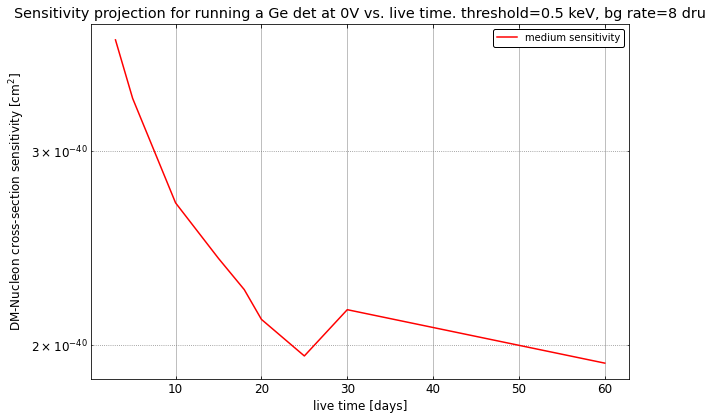

In [30]:
refval = 1e-40 # reference cross section to pass to OI code, in units of cm^2

tm = "Ge"
threshold = 0.5
upperthreh = 50
cutefficiency = 0.8
#time_elapsed = 10
bgrate = 8

time_array = [3, 5, 10, 15, 18, 20, 25, 30, 60]
sensitivity_at_mass = []

for time_elapsed in time_array:

    outvals_list = []

    for test in range(20):

        eventenergies, effrange, exposure = generate_spec(tm=tm, threshold=threshold, 
                                                          upperthreh=upperthreh,
                                                          cutefficiency=cutefficiency,
                                                          time_elapsed=time_elapsed,
                                                          bgrate=bgrate)

        candidatevals = np.geomspace(1.5, 15, num=25) # dark matter masses in GeV/c^2

        outvals, oi0, oi1 = optimuminterval(
            eventenergies,
            signalmodel,
            candidatevals,
            refval,
            effrange,
            exposure,
        )
        outvals_list.append(outvals)

    # get the maximum and minimum outvals for each DM mass
    #print (outvals_list)

    outvals_list = np.array(outvals_list)
    max_outvals = np.max(outvals_list, axis=0)
    min_outvals = np.min(outvals_list, axis=0)
    avg_outvals = (max_outvals+min_outvals)/2
    
    sensitivity_at_mass.append(avg_outvals[6])
    
    
fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/1))

ax.loglog(
    time_array,
    sensitivity_at_mass,
    color='r',
    label="medium sensitivity",
)

plt.xscale('linear')
plt.yscale('log')
ax.set_xlabel(r"live time [days]")
ax.set_ylabel(r"DM-Nucleon cross-section sensitivity [cm$^2$]")

ax.set_title("Sensitivity projection for running a "+tm+" det at 0V vs. live time. threshold="+str(threshold)+" keV, bg rate="+str(bgrate)+" dru")
ax.legend(loc="upper right", edgecolor='k', framealpha=1)
ax.grid(visible=True)
ax.grid(which="Minor", linestyle='dotted', color='gray')


ax.tick_params(which="both", direction="in", right=True, top=True)

fig.tight_layout()
